In [ ]:
import torch, os, json, sys
sys.path.append('..')
from datasets.pdbbind import PDBBind
from model.wrapper import ModelWrapper
import numpy as np
from utils import fft
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
from PIL import Image
import matplotlib as mpl
from pymol import cmd
import pandas as pd

In [2]:
import argparse
args = argparse.Namespace()
args.__dict__.update({
    'pdbbind_dir': "../data/PDBBind_processed",
    'receptor_radius': 30,
    'c_alpha_max_neighbors': 10,
    'atom_radius': 5,
    'atom_max_neighbors': 8,
    'all_atoms': True,
    'overfit': False,
    'max_lig_size': np.nan,
    'max_protein_len': np.nan,
})

In [3]:
model = ModelWrapper.load_from_checkpoint("../model_checkpoints/ESF_N.ckpt").cpu()

Checking RBF Frankel transform, l= 0 [1.         0.99999992 1.         1.         1.        ]
Checking RBF Frankel transform, l= 1 [0.99395923 0.99958113 0.99999899 1.         1.        ]
Checking RBF Frankel transform, l= 2 [0.98881194 0.99921396 0.99999807 1.         1.        ]


In [4]:
dataset = PDBBind(args, split_path="../splits/timesplit_test", return_all=True)

In [5]:
def get_image(cache, field, idx=0, symmetric_norm=True, cmap='viridis'):
    im = fft.ifft(cache, field)[idx,...,field.shape[-1]//2]
    if symmetric_norm:
        im = im / im.abs().max()
        im = im / 2 + 0.5
    else:
        im = (im - im.min()) / (im.max() - im.min())
    im = mpl.colormaps[cmap](im)
    im = Image.fromarray(np.flip(np.uint8(im*255).transpose(1,0,2), 0))
    im = im.resize((400, 400))
    return im

def get_pymol_image(pdb_id, coords=(0,0,0), type='ligand', z_pos=40, z_range=(30, 60)):
    cmd.reinitialize()
    cmd.do(f'fetch {pdb_id}')
    cmd.remove('resn hoh')
    cmd.set('depth_cue', 0)
    if type == 'ligand':
        cmd.hide('cartoon', 'polymer')
        cmd.set('ray_shadows', 0)
    elif type == 'pocket':
        cmd.show('cartoon', 'polymer')
        cmd.spectrum('count', 'rainbow', 'polymer')
        cmd.hide('sticks', 'hetatm')
    cmd.set_view(np.array([
        1, 0, 0,\
        0, 1, 0,\
        0, 0, 1,\
        0.000000000,    0.000000000, -z_pos,\
       *coords, *z_range,  -20.000000000]))
    cmd.png('/tmp/tmp.png', 640, 640)

    im = Image.open('/tmp/tmp.png')
    return im

## Figure 1 - overview

In [6]:
model.tr_cache.initialize(R_grid_spacing=0.25, R_grid_diameter=20)

In [7]:
batch = dataset[0]
prot_out = model.protein_model(batch, key="receptor", radius=False, all_atoms=True)
ligand_out = model.ligand_model(batch, key="ligand", radius=True)

In [8]:
lig_pos = batch['ligand'].pos
prot_pos = batch['receptor'].pos
prot_pos = prot_pos - lig_pos.mean(0)
lig_pos = lig_pos - lig_pos.mean(0)
prot_mask = prot_pos.norm(dim=-1) < 10
lig_field = model.tr_cache.render_fft(lig_pos, ligand_out)
prot_field = model.tr_cache.render_fft(prot_pos[prot_mask], prot_out[prot_mask])

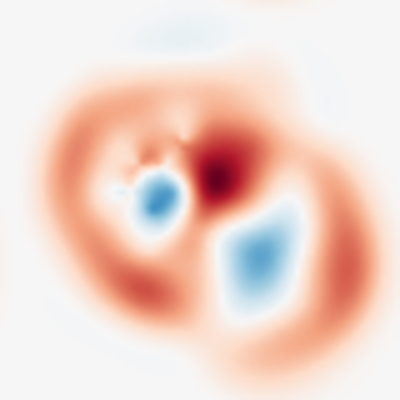

In [9]:
get_image(model.tr_cache, lig_field, idx=3, cmap='RdBu')

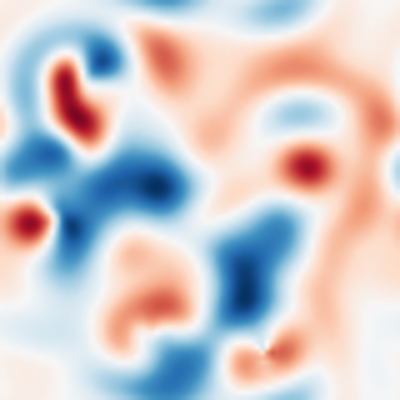

In [10]:
get_image(model.tr_cache, prot_field, idx=3, cmap='RdBu')

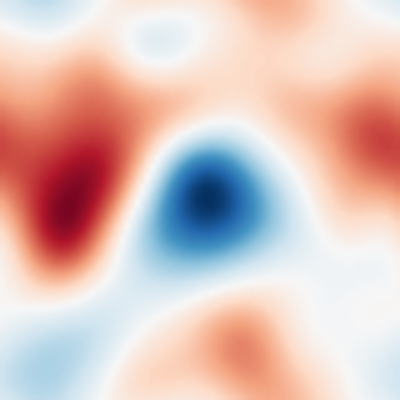

In [11]:
im = fft.cross_correlate(model.tr_cache, prot_field, lig_field).sum(0)
im = im[...,im.shape[-1]//2]
im = im / im.abs().max()
im = im / 2 + 0.5
im = mpl.colormaps['RdBu'](im)
im = Image.fromarray(np.flip(np.uint8(im*255).transpose(1,0,2), 0))
im.resize((400, 400))

## Figures 2, 3 - scalar fields

PyMOL>fetch 6qqw
TITLE     Crystal structure of TrmD, a tRNA-(N1G37) methyltransferase, from Mycobacterium abscessus in complex with inhibitor
 ExecutiveLoad-Detail: Detected mmCIF
 CmdLoad: "./6qqw.cif" loaded as "6qqw".
 Ray: render time: 0.16 sec. = 22002.3 frames/hour (0.16 sec. accum.).
PyMOL>fetch 6qqw
TITLE     Crystal structure of TrmD, a tRNA-(N1G37) methyltransferase, from Mycobacterium abscessus in complex with inhibitor
 ExecutiveLoad-Detail: Detected mmCIF
 CmdLoad: "./6qqw.cif" loaded as "6qqw".
 Ray: render time: 1.68 sec. = 2147.2 frames/hour (1.84 sec. accum.).
PyMOL>fetch 6jap
TITLE     Crystal structure of ABC transporter alpha-glycoside-binding mutant protein R356A in complex with sucrose
 ExecutiveLoad-Detail: Detected mmCIF
 CmdLoad: "./6jap.cif" loaded as "6jap".
 Ray: render time: 0.17 sec. = 20979.9 frames/hour (2.01 sec. accum.).
PyMOL>fetch 6jap
TITLE     Crystal structure of ABC transporter alpha-glycoside-binding mutant protein R356A in complex with sucrose

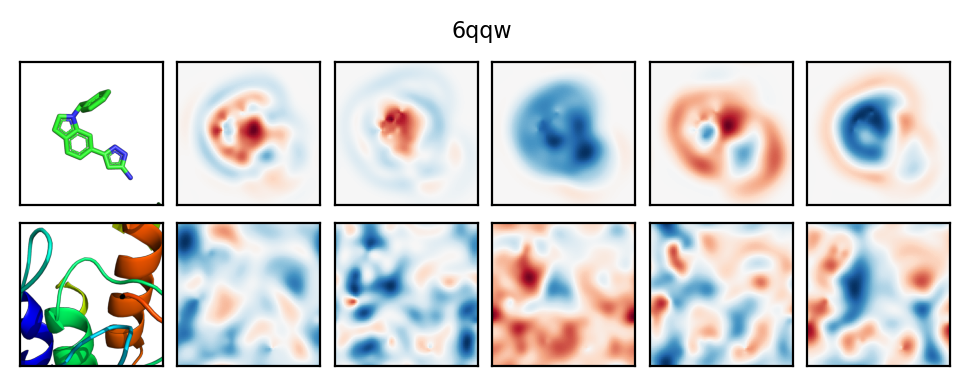

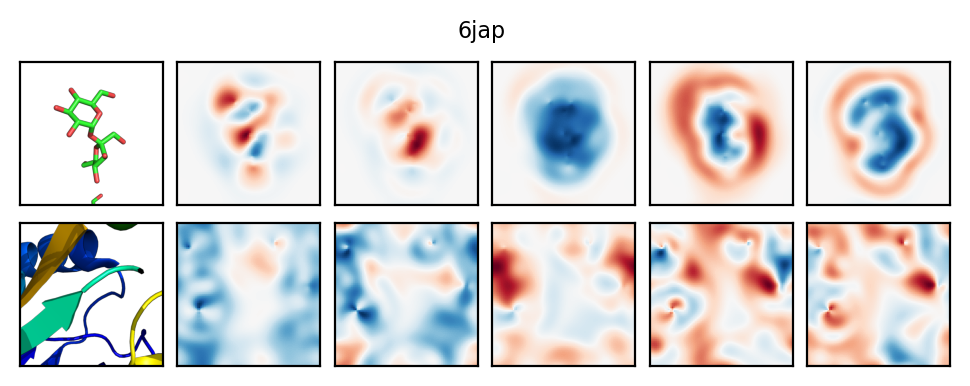

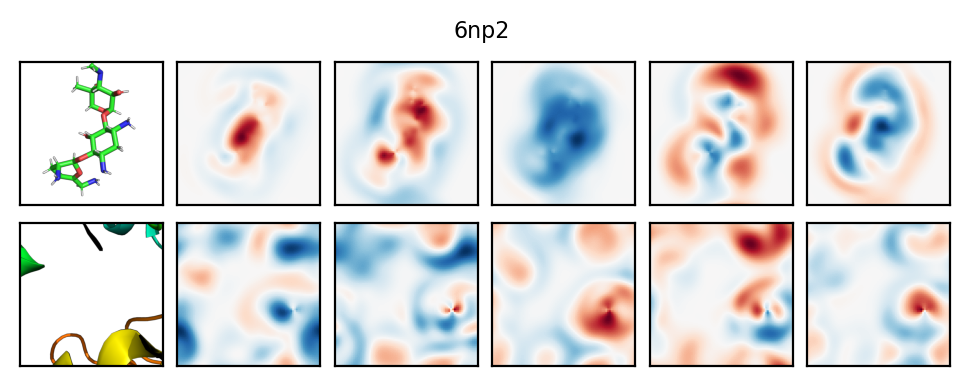

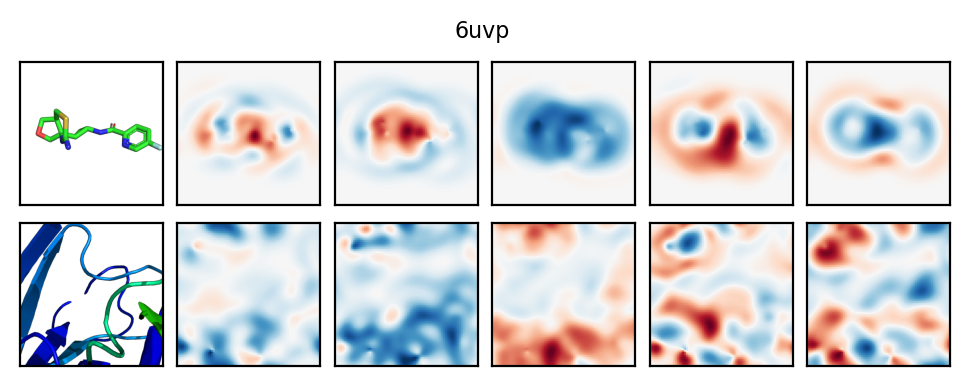

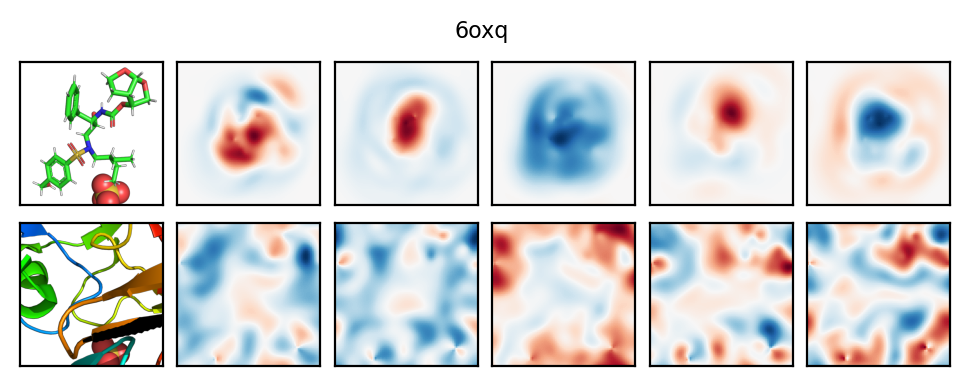

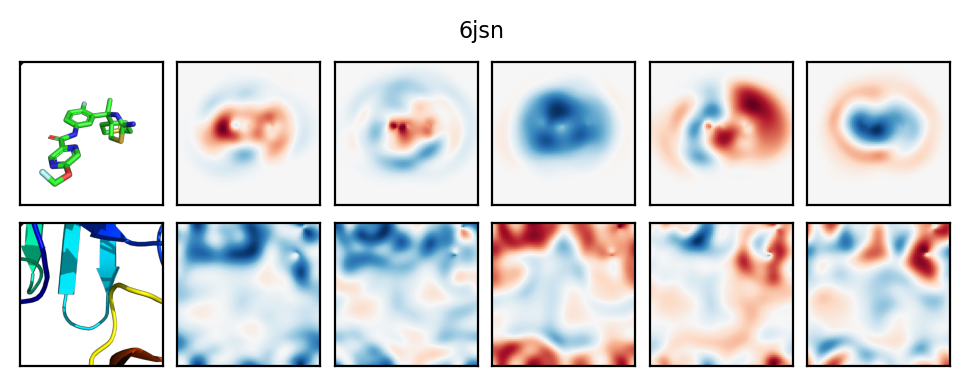

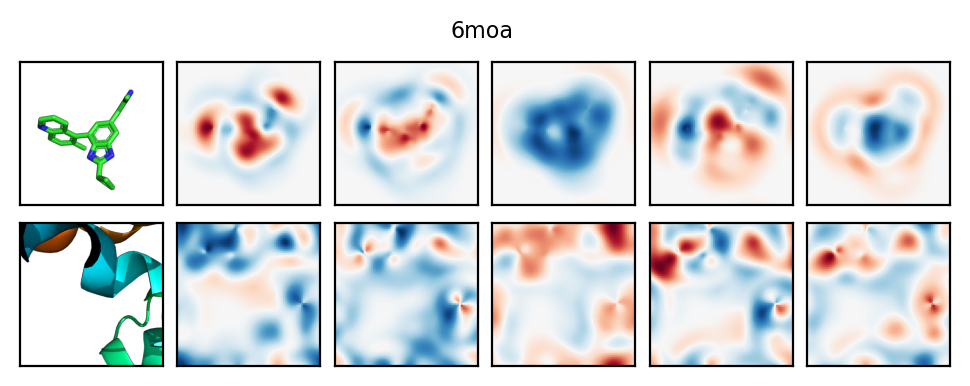

In [12]:
for i in range(12):
    batch = dataset[i]
    if batch.name.strip() not in ['6qqw', '6jap', '6np2', '6uvp', '6oxq', '6jsn', '6moa']: continue # exclude peptides
    prot_out = model.protein_model(batch, key="receptor", radius=False, all_atoms=True)
    ligand_out = model.ligand_model(batch, key="ligand", radius=True)
    
    lig_pos = batch['ligand'].pos
    prot_pos = batch['receptor'].pos
    pocket_center = lig_pos.mean(0)
    prot_pos = prot_pos - pocket_center
    lig_pos = lig_pos - pocket_center
    prot_mask = (prot_pos.abs() < 10).sum(1) == 3
    lig_field = model.tr_cache.render_fft(lig_pos, ligand_out)
    prot_field = model.tr_cache.render_fft(prot_pos[prot_mask], prot_out[prot_mask])

    fig = plt.figure(figsize=(6, 2), dpi=200)
    gs = fig.add_gridspec(2, 6, hspace=0.1,wspace=0.1)
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    
    lig_im = fft.ifft(model.tr_cache, lig_field)
    prot_im = fft.ifft(model.tr_cache, prot_field)
    
    ax = fig.add_subplot(gs[0,0])
    ax.imshow(get_pymol_image(batch.name, pocket_center, type='ligand'))
    ax.set_xticks([]); ax.set_yticks([])
    
    ax = fig.add_subplot(gs[1,0])
    ax.imshow(get_pymol_image(batch.name, pocket_center, type='pocket'))
    ax.set_xticks([]); ax.set_yticks([])
    for i in range(5):
        ax = fig.add_subplot(gs[0,i+1])
        this_im = lig_im[i,...,lig_im.shape[-1]//2].T
        ax.imshow(this_im, cmap='RdBu', vmin=-this_im.abs().max(), vmax=this_im.abs().max(), origin='lower')
        ax.set_xticks([]); ax.set_yticks([])
    
        ax = fig.add_subplot(gs[1,i+1])
        this_im = prot_im[i,...,prot_im.shape[-1]//2].T
        ax.imshow(this_im, cmap='RdBu', vmin=-this_im.abs().max(), vmax=this_im.abs().max(), origin='lower')
        ax.set_xticks([]); ax.set_yticks([])
    
    fig.suptitle(batch.name.strip(), x=0.51, fontsize=8)
    plt.savefig(f'../figures/{batch.name}.pdf', bbox_inches='tight', pad_inches = 0)

## Figure 5 - PDE10A

 Ray: render time: 2.60 sec. = 1382.5 frames/hour (12.12 sec. accum.).


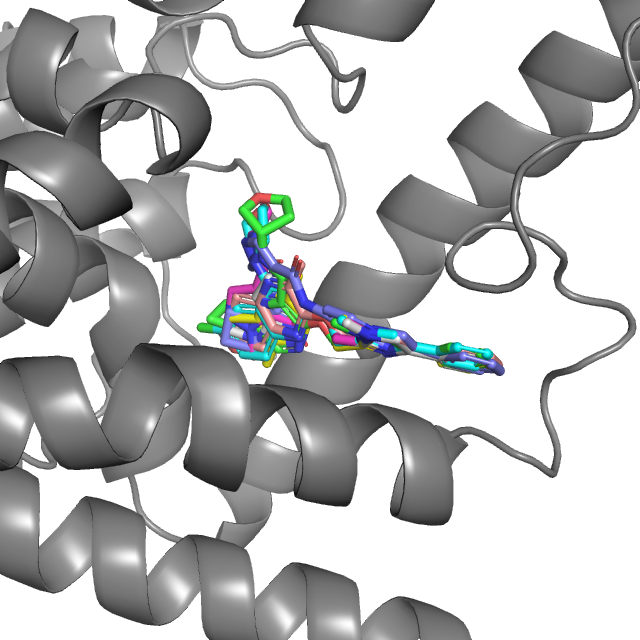

In [13]:
df = pd.read_csv('../paper_results/docking/gnina/pde10a/default.csv')
pdb_ids = df.name[df.rmsd != df.rmsd]
cmd.reinitialize()
for pdb_id in pdb_ids:
    path = f"../data/pde10a/{pdb_id}/{pdb_id}_ligand_aligned.sdf"
    cmd.load(path)
cmd.load('../data/pde10a/5sfs/5sfs_protein_processed.pdb')
#cmd.show('surface', 'polymer')
cmd.set('ray_shadows', 0)
cmd.color('grey', 'polymer')
cmd.set_view([    
     0.310746908,   -0.923686028,   -0.224141747,\
    -0.017037462,    0.230364934,   -0.972953141,\
     0.950339317,    0.306161672,    0.055847809,\
     0.000000000,   -0.000000000,  -88.662185669,\
    29.944723129,  -45.894161224,  -12.599908829,\
    24.247734070,  153.076705933,  -20.000000000 ])
cmd.png('/tmp/tmp.png', 640, 640)
im = Image.open('/tmp/tmp.png')
im